In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Import test set:


In [2]:
# full train set:
train_df = pd.read_csv("../data/train_clean.csv")

# full test set: 
test_df  = pd.read_csv("../data/test_clean.csv")

## Test on best model: Numeric Neural Network

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append("../scripts")
import data_cleaning

# --------------------------
# Load + clean
# --------------------------
data = pd.read_csv("../data/train.csv")
data = data_cleaning.clean_data(data)

numeric_cols = [
    "funny", "wow", "sad", "likes", "disagree",
    "toxicity", "severe_toxicity", "obscene", "sexual_explicit",
    "identity_attack", "insult", "threat"
]

X_num = data[numeric_cols].values.astype(np.float32)
y_num = data["rating_rejected"].values  # 0 = not rejected, 1 = rejected

# Same split as before (80/20, stratified, random_state=42)
X_train_num, X_val_num, y_train_num, y_val_num = train_test_split(
    X_num,
    y_num,
    test_size=0.2,
    random_state=42,
    stratify=y_num
)

# Scale numeric features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num).astype(np.float32)
X_val_num_scaled   = scaler.transform(X_val_num).astype(np.float32)

In [6]:
class NumericDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()  # 0/1

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_num_dataset = NumericDataset(X_train_num_scaled, y_train_num)
val_num_dataset   = NumericDataset(X_val_num_scaled,   y_val_num)

train_num_loader = DataLoader(train_num_dataset, batch_size=batch_size, shuffle=True)
val_num_loader   = DataLoader(val_num_dataset,   batch_size=batch_size, shuffle=False)

In [7]:
def get_activation(name):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unknown activation: {name}")

class NumNN(nn.Module):
    def __init__(self, input_dim, hidden_size, activation):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            get_activation(activation),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()   # outputs P(rejected=1)
        )

    def forward(self, x):
        return self.net(x)

def train_num_model(model, optimizer, train_loader, val_loader,
                    max_epochs=20, patience=3, device="cpu"):

    criterion = nn.BCELoss()
    model.to(device)

    best_f1 = 0.0
    best_state = None
    wait = 0

    for epoch in range(1, max_epochs + 1):
        # ---- TRAIN ----
        model.train()
        train_losses = []

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).float().unsqueeze(1)  # (batch, 1)

            optimizer.zero_grad()
            probs = model(xb)                        # (batch, 1)
            loss = criterion(probs, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = float(np.mean(train_losses))

        # ---- VALIDATION ----
        model.eval()
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                probs = model(xb)                    # (batch, 1)
                preds = (probs > 0.5).long().cpu().numpy().flatten()  # 0/1

                val_preds.extend(preds.tolist())
                val_targets.extend(yb.cpu().numpy().tolist())

        val_f1 = f1_score(val_targets, val_preds)
        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f}")

        # ---- EARLY STOPPING ----
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return best_f1, model


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = X_train_num_scaled.shape[1]

BEST_ACTIVATION = "tanh"
BEST_HIDDEN_SIZE = 256
BEST_LR = 0.01

final_model = NumNN(
    input_dim=input_dim,
    hidden_size=BEST_HIDDEN_SIZE,
    activation=BEST_ACTIVATION
)

optimizer = torch.optim.Adam(final_model.parameters(), lr=BEST_LR)

best_val_f1, trained_final_model = train_num_model(
    final_model,
    optimizer,
    train_num_loader,
    val_num_loader,
    max_epochs=20,
    patience=3,
    device=device
)

print("\nFinal numbers-only NN:")
print("Best validation F1:", best_val_f1)

Epoch 1 | Train Loss: 0.2091 | Val F1: 0.0142
Epoch 2 | Train Loss: 0.2091 | Val F1: 0.0810
Epoch 3 | Train Loss: 0.2091 | Val F1: 0.2198
Epoch 4 | Train Loss: 0.2094 | Val F1: 0.0960
Epoch 5 | Train Loss: 0.2095 | Val F1: 0.3291
Epoch 6 | Train Loss: 0.2096 | Val F1: 0.1197
Epoch 7 | Train Loss: 0.2096 | Val F1: 0.1231
Epoch 8 | Train Loss: 0.2095 | Val F1: 0.1995
Early stopping.

Final numbers-only NN:
Best validation F1: 0.3291093689757101



Classification report (validation set):

              precision    recall  f1-score   support

           0     0.9415    0.9920    0.9661    297559
           1     0.5206    0.1234    0.1995     20929

    accuracy                         0.9349    318488
   macro avg     0.7310    0.5577    0.5828    318488
weighted avg     0.9138    0.9349    0.9157    318488



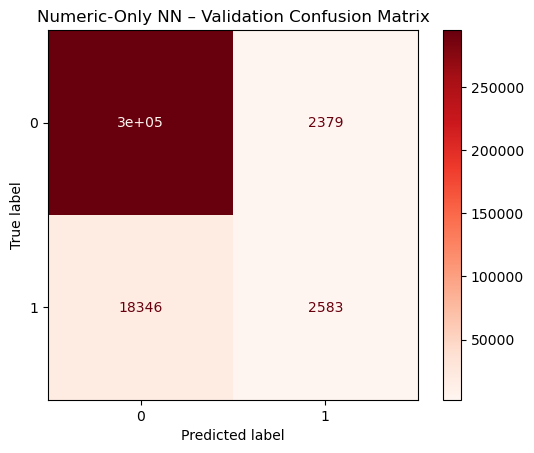

In [9]:
trained_final_model.eval()

with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val_num_scaled).float().to(device)
    probs_val = trained_final_model(X_val_tensor).cpu().numpy().flatten()
    preds_val = (probs_val > 0.5).astype(int)

print("\nClassification report (validation set):\n")
print(classification_report(y_val_num, preds_val, digits=4))

cm = confusion_matrix(y_val_num, preds_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Reds)
plt.title("Numeric-Only NN – Validation Confusion Matrix")
plt.show()